# Crafting a first data set. 

Things that need to be done: 
- find a set of satellite images that is tagged with locations
- find a granular poverty data set taht includes locations taht can be mapped to the images
- join the datasets 

Read in image data

In [17]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt

from collections import defaultdict
from glob import glob
import random as rd
import pylab as pl
import pandas as pd
import re
from sklearn import decomposition


from PIL import Image
import PIL.ImageOps

from skimage import io, color
import matplotlib.image as mpimg
from skimage.transform import resize

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.metrics import classification_report, mean_squared_error

import seaborn as sns
from sklearn.metrics import confusion_matrix

import ntpath
import geopandas as gpd
from shapely.geometry import Point, Polygon
from fiona.crs import from_epsg


In [2]:
#get all the pathlinks to the images
raw_images_links = glob("/Users/johannes/Desktop/Hertie/images/*")

In [5]:
#transform the images into arrays
mali_arrays = [np.array(Image.open(file_name)) for file_name in raw_images_links]
mali_arrays[0].shape

(256, 256, 4)

In [10]:
#flatten the data and resize if necessary

#resize the data and flatten it
def transform(dataset):
    new_list = []
    for i in range(len(dataset)):
        #resize the image
        temp2 = resize(dataset[i], (256, 256), Image.NEAREST)
        #flatten it
        new_list.append(temp2.flatten())

    return new_list

#do this for mali
mali_transform = transform(mali_arrays)

In [13]:
mali_transform[0].shape

(262144,)

In [14]:
#scale the data using StandardScaler
#StandarScaler normalizes the images by subtracting the mean and dividing by the unit variance. 
scaler = StandardScaler()
scaler.fit(mali_transform)
data_set = scaler.fit_transform(mali_transform)

In [20]:
# Get the location of the images 
image_geodf = gpd.GeoDataFrame() # Create an empty geopandas GeoDataFrame
for i in range(len(raw_images_links)):
    #extract an array of the geo points from the file name 
    point_array = [float(point) for point in str.split(ntpath.basename(raw_images_links[i][:-4]),"_")]

    #iterate through the geopoints and build tuples
    geo_point = [(point_array[0], point_array[1]),
                (point_array[0], point_array[3]),
                (point_array[2], point_array[1]),
                (point_array[2], point_array[3])]

    # Create a Shapely polygon from the coordinate-tuple list
    image_geodf.loc[i, 'geometry'] = Polygon(geo_point)

    # Set the GeoDataFrame's coordinate system to WGS84 (i.e. epsg code 4326)
image_geodf.crs = from_epsg(4326)

/Users/johannes/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [25]:
#doesn't work we can't just tack the multidimensional array onto the geoframe. 
#will have to do a work around but it'll work out :) 
for i in range(len(data_set)):
    print(i)
    print(data_set[i])
    image_geodf.loc[i,"img"] = data_set[i]

0
[ 0.27294771  0.15314924  0.26865338 ... -1.04812446 -0.91621977
  0.07506723]


ValueError: cannot set using a multi-index selection indexer with a different length than the value

In [ ]:
image_geodf.head()

In [ ]:
### ADD THE OUTCOME VARIABLE HERE THROUGH A GEOMERGE



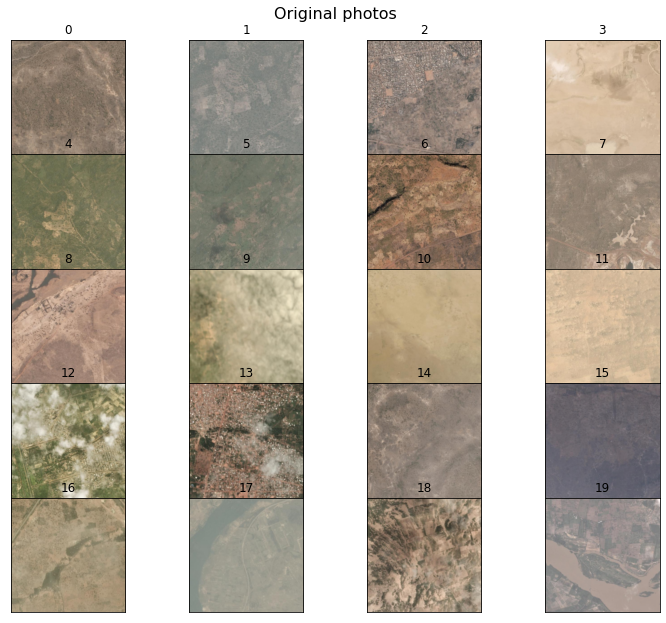

In [16]:
### peak into the data

n_col = 5
n_row = 4
## show the original images
plt.figure(figsize=(2. * n_col, 2.26 * n_row))
plt.suptitle('Original photos', size=16)

#loop through some reandom images
for i, comp in enumerate(data_set[:n_col*n_row]):
    plt.subplot(n_col, n_row, i + 1)
    comp = scaler.inverse_transform(comp)
    comp = (comp * 255).astype(np.uint8)
    plt.imshow(comp.reshape(256,256,4))
    plt.title(i)
    plt.xticks(())
    plt.yticks(())
plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)